# Linear Regression - California Housing

In [294]:
import pandas as pd
import numpy as np
import seaborn as sns 
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Caricamento dataset

In [295]:
data = fetch_california_housing(as_frame=True)
df = data.frame

In [296]:
# rimozione di outlier assurdi 
df = df[df['MedHouseVal'] < 10]

In [297]:
# Split iniziale
X = df.drop("MedHouseVal", axis=1)
y = df["MedHouseVal"]

# Trasformazione log del target per ridurre l’impatto outlier
y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (16512, 8), Test: (4128, 8)


## Pairplot

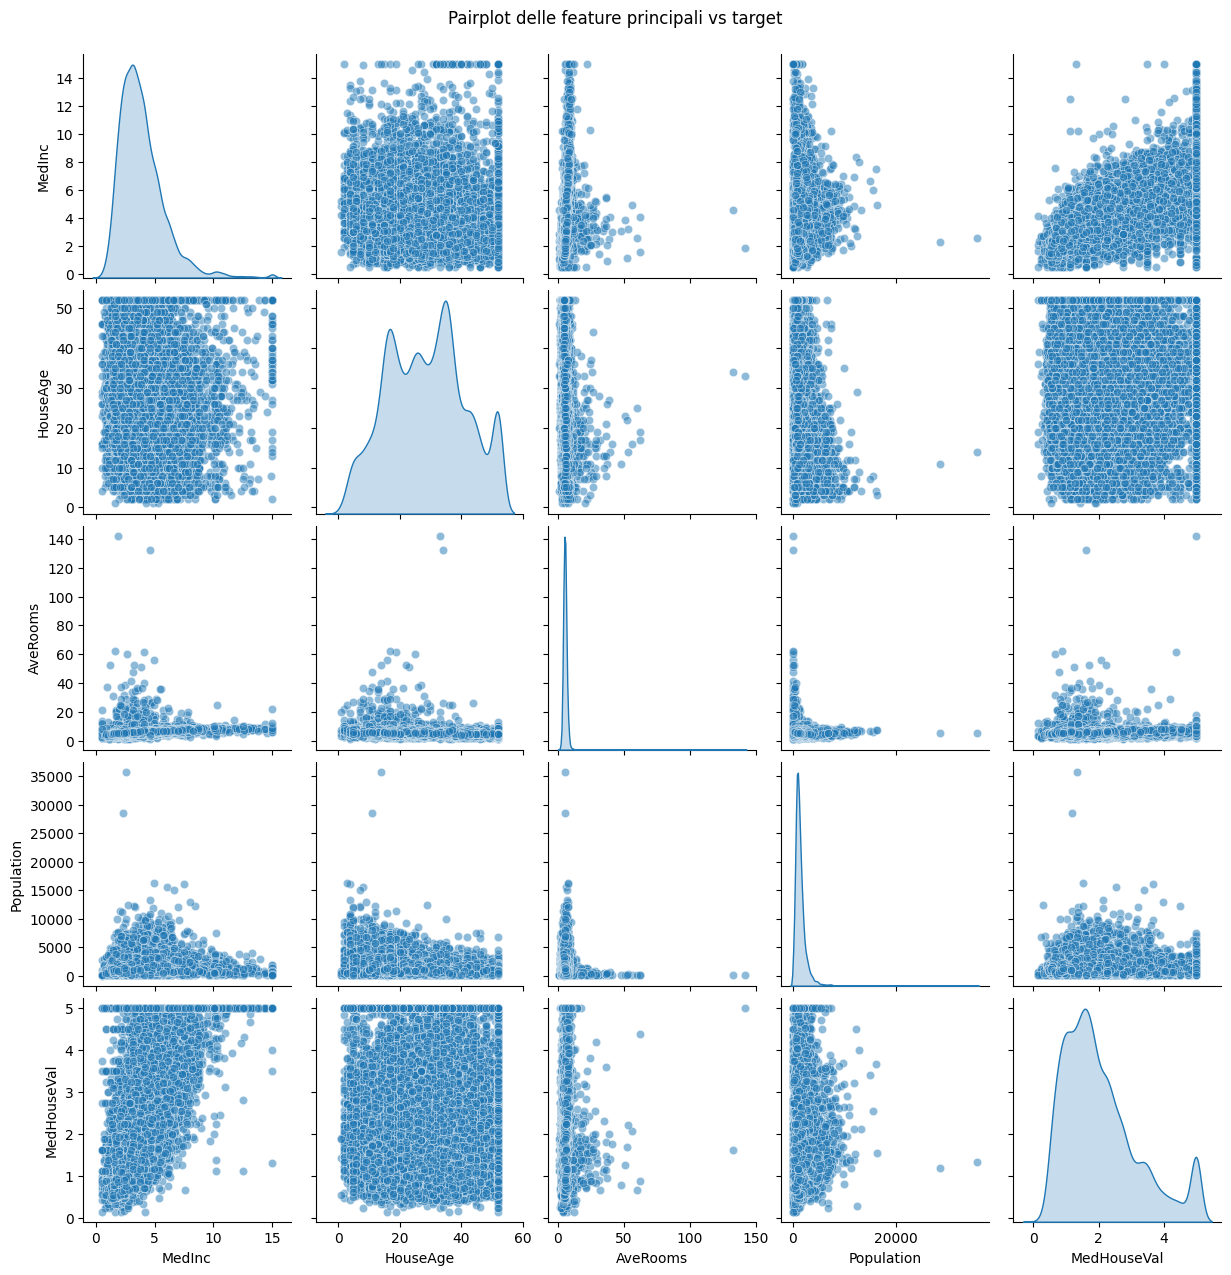

In [298]:
selected_cols = ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'MedHouseVal']
sns.pairplot(df[selected_cols], diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Pairplot delle feature principali vs target', y=1.02)
plt.show()

In [299]:
log_features = ['Population', 'AveRooms', 'AveBedrms']
for col in log_features:
    X_train[col + '_log'] = np.log1p(X_train[col])
    X_test[col + '_log'] = np.log1p(X_test[col])

## Rimozione outlier

### IQR

In [300]:
# rimozione di outlier solo da train
# Metodo: rimuovere punti troppo distanti dalla mediana
q1 = y_train.quantile(0.25)
q3 = y_train.quantile(0.75)
iqr = q3 - q1


lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr


mask = (y_train >= lower) & (y_train <= upper)
X_train = X_train[mask]
y_train = y_train[mask]
    

In [301]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Trasformazioni logaritmiche

In [302]:
log_features = ['Population', 'AveRooms', 'AveBedrms']
for col in log_features:
    X_train[col + '_log'] = np.log1p(X_train[col])
    X_test[col + '_log'] = np.log1p(X_test[col])

### Feature engineering

In [303]:
coast_longitude = -122.5
def distance_to_coast(lat, lon, coast_lon=coast_longitude):
    return np.abs(lon - coast_lon)

X_train['Households'] = X_train['Population'] / (X_train['AveOccup'] + 1e-5)
X_test['Households'] = X_test['Population'] / (X_test['AveOccup'] + 1e-5)

X_train['Distance_to_Coast'] = distance_to_coast(X_train['Latitude'], X_train['Longitude'])
X_test['Distance_to_Coast'] = distance_to_coast(X_test['Latitude'], X_test['Longitude'])

X_train['Income_Rooms'] = X_train['MedInc'] * X_train['AveRooms']
X_test['Income_Rooms'] = X_test['MedInc'] * X_test['AveRooms']

X_train['MedInc_squared'] = X_train['MedInc']**2
X_test['MedInc_squared'] = X_test['MedInc']**2

X_train['MedInc_cubed'] = X_train['MedInc']**3
X_test['MedInc_cubed'] = X_test['MedInc']**3

In [304]:
# Standardizzazione (Z-score)
print("\n--- 8. Standardizzazione ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


--- 8. Standardizzazione ---


In [305]:
#Modellazione (Linear, Ridge, Lasso)
print("\n--- 9. Addestramento Modelli ---")

models = {
    'Linear': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001, max_iter=10000)
}

predictions = {}
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train_log)
    y_pred_log = model.predict(X_test_scaled)
    
    # Riportare i valori predetti al dominio originale
    y_pred = np.expm1(y_pred_log)
    y_test_orig = np.expm1(y_test_log.values)
    
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
    r2 = r2_score(y_test_orig, y_pred)
    mae = mean_absolute_error(y_test_orig, y_pred)
    
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2, 'MAE': mae})
    predictions[name] = y_pred
    
    print(f"{name}: RMSE={rmse:.4f} | R2={r2:.4f} | MAE={mae:.4f}")



--- 9. Addestramento Modelli ---


ValueError: Found input variables with inconsistent numbers of samples: [15642, 16512]

In [ ]:
results_df = pd.DataFrame(results)
print("\n--- Confronto Modelli ---")
print(results_df.to_string(index=False))


--- Confronto Modelli ---
 Model     RMSE       R2      MAE
Linear 0.668414 0.659055 0.463166
 Ridge 0.679252 0.647909 0.475150
 Lasso 0.681649 0.645420 0.478759


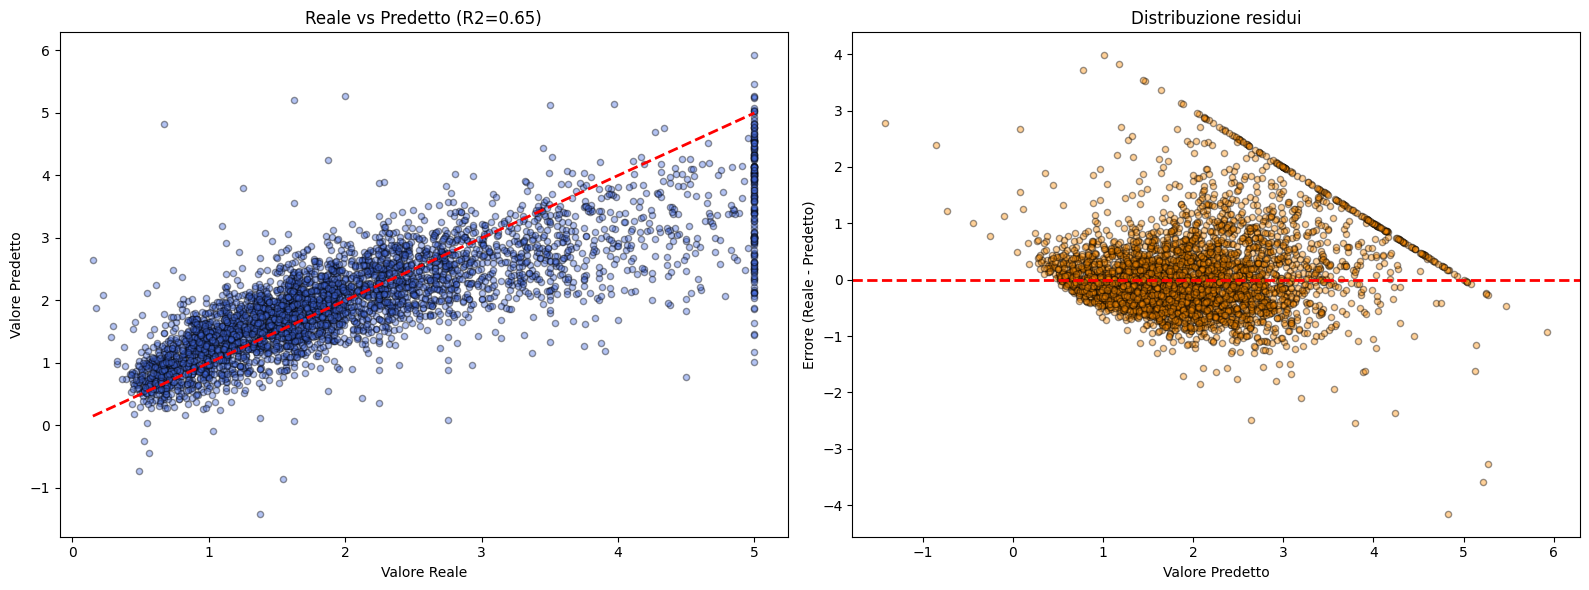

In [ ]:
y_pred_linear = predictions['Linear']
residuals = y_test_orig - y_pred_linear

fig, axs = plt.subplots(1, 2, figsize=(16,6))

axs[0].scatter(y_test_orig, y_pred_linear, alpha=0.4, color='royalblue', edgecolor='k', s=20)
axs[0].plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
axs[0].set_title('Reale vs Predetto')
axs[0].set_xlabel('Valore Reale')
axs[0].set_ylabel('Valore Predetto')

axs[1].scatter(y_pred_linear, residuals, alpha=0.4, color='darkorange', edgecolor='k', s=20)
axs[1].axhline(0, color='red', linestyle='--', lw=2)
axs[1].set_title('Distribuzione residui')
axs[1].set_xlabel('Valore Predetto')
axs[1].set_ylabel('Errore (Reale - Predetto)')

plt.tight_layout()
plt.show()